# Benchmark Performance For Log Loss = Binary Cross Entropy
## Numpy vs different Cython implementations
With $\eta = \mathrm{raw\_prediction}$ and $\mathrm{y_{pred}} = expit(\eta) = \frac{exp(\eta)}{1 + exp(\eta)}$ we have
$$log\_loss =  log(1 + exp(\eta)) - y_{true} \eta$$

In [1]:
%load_ext cython

In [2]:
import numpy as np
from scipy.special import expit


# numpy ufunc version
# Note: log1p(exp(x)) is faster than logaddexp(x)
def np_logloss(y_true, raw):
    # logaddexp(0, x) = log(1 + exp(x))
    # return np.logaddexp(0, raw) - y_true * raw
    #
    # numerically stable, but slower
    # pos = raw > 0
    # out = - y_true * raw
    # out[pos] += raw[pos] + np.log1p(np.exp(-raw[pos]))
    # out[~pos] += np.log1p(np.exp(-raw[~pos]))
    # return out
    #
    # return np.where(raw >= 0, raw + np.log1p(np.exp(-raw)) - y_true * raw, np.log1p(np.exp(raw)) - y_true * raw)
    #
    # fast, but unstable for raw > 700
    return np.log1p(np.exp(raw)) - y_true * raw
    

def np_gradient(y_true, raw):
    return expit(raw) - y_true

In [3]:
%%cython -3
# distutils: extra_compile_args = -O3
# cython: cdivision=True
# cython: boundscheck=False
# cython: wraparound=False

import cython
from cython.parallel import prange
import numpy as np

from libc.math cimport exp, log, log1p
cimport numpy as np
from scipy.special.cython_special cimport expit

np.import_array()


ctypedef double (*fpointer)(double, double) nogil


cdef void generic_loop(fpointer f, double[::1] y_true, double[::1] raw, double[::1] out):
    cdef:
        int i
        int size = y_true.shape[0]
    with nogil:
        for i in range(size):
            out[i] = f(y_true[i], raw[i])

### 1. C level functions
cdef double c_logloss(double y_true, double raw) nogil:
    if raw <= 0:
        return log1p(exp(raw)) - y_true * raw
    else:
        # log(1 + exp(x)) = x + log(1 + exp(-x))
        return raw + log1p(exp(-raw)) - y_true * raw

    
cdef inline double c_gradient(double y_true, double raw) nogil:
        return expit(raw) - y_true


### 2. ndarray via loop over C level functions
def p_logloss(double[::1] y_true, double[::1] raw):
    cdef:
        int n_samples
        int i
        cdef double[::1] out = np.empty_like(y_true)
    
    n_samples = y_true.shape[0]
    for i in range(n_samples):
        out[i] = c_logloss(y_true[i], raw[i])
        
    return out


def p_gradient(double[::1] y_true, double[::1] raw):
    cdef:
        int n_samples
        int i
        cdef double[::1] out = np.empty_like(y_true)
    
    n_samples = y_true.shape[0]
    for i in range(n_samples):
        out[i] = c_gradient(y_true[i], raw[i])
        
    return out


### 3. ndarray via generic loop, i.e. function pointer to C level functions
def p_logloss_generic(double[::1] y_true, double[::1] raw):
    cdef:
        cdef double[::1] out = np.empty_like(y_true)
    
    generic_loop(c_logloss, y_true, raw, out)        
    return out


def p_gradient_generic(double[::1] y_true, double[::1] raw):
    cdef:
        cdef double[::1] out = np.empty_like(y_true)
    
    generic_loop(c_gradient, y_true, raw, out)        
    return out


### 4. Class implementation, similar to 1. and 2.
cdef class Logloss():
    
    @staticmethod
    cdef double static_logloss(double y_true, double raw) nogil:
        if raw <= 0:
            return log1p(exp(raw)) - y_true * raw
        else:
            # log(1 + exp(x)) = x + log(1 + exp(-x))
            return raw + log1p(exp(-raw)) - y_true * raw
    
    @staticmethod
    cdef double static_gradient(double y_true, double raw) nogil:
            return expit(raw) - y_true

    def loss(self, double[::1] y_true, double[::1] raw):
        cdef:
            int n_samples
            int i
            cdef double[::1] out = np.empty_like(y_true)
        
        n_samples = y_true.shape[0]
        for i in range(n_samples):
            out[i] = Logloss.static_logloss(y_true[i], raw[i])
            
        return np.asarray(out)
    
    def gradient(self, double[::1] y_true, double[::1] raw):
        cdef:
            int n_samples
            int i
            cdef double[::1] out = np.empty_like(y_true)
        
        n_samples = y_true.shape[0]
        for i in range(n_samples):
            out[i] = Logloss.static_gradient(y_true[i], raw[i])
            
        return np.asarray(out)

    def loss_generic(self, double[::1] y_true, double[::1] raw):
        cdef:
            cdef double[::1] out = np.empty_like(y_true)

        generic_loop(self.static_logloss, y_true, raw, out)
        return out
    
    def gradient_generic(self, double[::1] y_true, double[::1] raw):
        cdef:
            cdef double[::1] out = np.empty_like(y_true)

        generic_loop(self.static_gradient, y_true, raw, out)
        return out


### 5. Class using virtual inheritance, i.e. loop in base class
# is inherited to derived class
cdef class BaseLoss():

    cdef double _loss(self, double y_true, double raw) nogil:
        return 1.
    
    cdef double _gradient(self, double y_true, double raw) nogil:
        return 1.

    def loss(self, double[::1] y_true, double[::1] raw):
        cdef:
            int n_samples
            int i
            cdef double[::1] out = np.empty_like(y_true)

        n_samples = y_true.shape[0]
        for i in range(n_samples):
            out[i] = self._loss(y_true[i], raw[i])
            
        return np.asarray(out)
    
    def gradient(self, double[::1] y_true, double[::1] raw):
        cdef:
            int n_samples
            int i
            cdef double[::1] out = np.empty_like(y_true)

        n_samples = y_true.shape[0]
        for i in range(n_samples):
            out[i] = self._gradient(y_true[i], raw[i])
            
        return np.asarray(out)


cdef class Logloss_virtual(BaseLoss):

    cdef double _loss(self, double y_true, double raw) nogil:
        if raw <= 0:
            return log1p(exp(raw)) - y_true * raw
        else:
            # log(1 + exp(x)) = x + log(1 + exp(-x))
            return raw + log1p(exp(-raw)) - y_true * raw
        
    cdef double _gradient(self, double y_true, double raw) nogil:
        return expit(raw) - y_true

### Simple Timings

In [4]:
rng = np.random.default_rng(0)
y_true = rng.standard_normal(100_000, dtype=np.float64)
raw = rng.standard_normal(100_000, dtype=np.float64)

In [5]:
[np.sum(np_logloss(y_true, raw) - p_logloss(y_true, raw)),
 np.sum(np_logloss(y_true, raw) - p_logloss_generic(y_true, raw)),
 np.sum(np_logloss(y_true, raw) - Logloss().loss(y_true, raw)),
 np.sum(np_logloss(y_true, raw) - Logloss().loss_generic(y_true, raw)),
 np.sum(np_logloss(y_true, raw) - Logloss_virtual().loss(y_true, raw))
]

[1.27675647831893e-14,
 1.27675647831893e-14,
 1.27675647831893e-14,
 1.27675647831893e-14,
 1.27675647831893e-14]

In [6]:
%%timeit -r10 -n100
np_logloss(y_true, raw)

1.48 ms ± 89 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [7]:
%%timeit -r10 -n100
p_logloss(y_true, raw)

2.65 ms ± 110 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [8]:
%%timeit -r10 -n100
p_logloss_generic(y_true, raw)

2.54 ms ± 77.8 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [9]:
%%timeit -r10 -n100
Logloss().loss(y_true, raw)

2.57 ms ± 107 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [10]:
%%timeit -r10 -n100
Logloss().loss_generic(y_true, raw)

2.62 ms ± 64.6 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [11]:
%%timeit -r10 -n100
Logloss_virtual().loss(y_true, raw)

2.78 ms ± 157 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [12]:
[np.sum(np_gradient(y_true, raw) - p_gradient(y_true, raw)),
 np.sum(np_gradient(y_true, raw) - p_gradient_generic(y_true, raw)),
 np.sum(np_gradient(y_true, raw) - Logloss().gradient(y_true, raw)),
  np.sum(np_gradient(y_true, raw) - Logloss().gradient_generic(y_true, raw)),
 np.sum(np_gradient(y_true, raw) - Logloss_virtual().gradient(y_true, raw))
]

[0.0, 0.0, 0.0, 0.0, 0.0]

In [13]:
%%timeit -r10 -n500
np_gradient(y_true, raw)

647 µs ± 19.8 µs per loop (mean ± std. dev. of 10 runs, 500 loops each)


In [14]:
%%timeit -r10 -n500
p_gradient(y_true, raw)

722 µs ± 31.8 µs per loop (mean ± std. dev. of 10 runs, 500 loops each)


In [15]:
%%timeit -r10 -n500
p_gradient_generic(y_true, raw)

730 µs ± 19.4 µs per loop (mean ± std. dev. of 10 runs, 500 loops each)


In [16]:
%%timeit -r10 -n500
Logloss().gradient(y_true, raw)

718 µs ± 17.4 µs per loop (mean ± std. dev. of 10 runs, 500 loops each)


In [17]:
%%timeit -r10 -n500
Logloss().gradient_generic(y_true, raw)

854 µs ± 27 µs per loop (mean ± std. dev. of 10 runs, 500 loops each)


In [18]:
%%timeit -r10 -n500
Logloss_virtual().gradient(y_true, raw)

868 µs ± 22.9 µs per loop (mean ± std. dev. of 10 runs, 500 loops each)


### Benchmark Loss

In [19]:
from collections import OrderedDict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from neurtu import delayed, timeit, Benchmark


# See https://github.com/mwaskom/seaborn/issues/1986
#g = sns.FacetGrid(df.wall_time.reset_index(), hue="function", height =5)
#g.map(plt.errorbar, "N", "mean", yerr=df.wall_time.reset_index()['std']);

# This works
# See https://stackoverflow.com/a/30428808
def errplot(x, y, yerr, **kwargs):
    ax = plt.gca()
    data = kwargs.pop("data")
    data.plot(x=x, y=y, yerr=yerr, kind="line", ax=ax, **kwargs)

In [20]:
n_samples = 1000_000
rng = np.random.default_rng(42)
y_pred = rng.standard_normal(n_samples)
raw = rng.standard_normal(n_samples)

func_list = [(np_logloss, "np_logloss"),
             (p_logloss, "p_logloss"),
             (p_logloss_generic, "p_logloss_generic"),
             (Logloss().loss, "Logloss().loss"),
             (Logloss().loss_generic, "Logloss().loss_generic"),
             (Logloss_virtual().loss, "Logloss_virtual().loss")
            ]

def benchmark_cases():
    for N in np.logspace(np.log10(10), np.log10(n_samples), 10).astype('int'):
        for func, name in func_list:
            tags = OrderedDict(N=N, function=name)
            yield delayed(func, tags=tags)(y_pred[:N], raw[:N])

In [21]:
%%time
bench = Benchmark(wall_time={'number': 1}, peak_memory=True, repeat=20)
df_loss = bench(benchmark_cases())

CPU times: user 11min 2s, sys: 43.6 s, total: 11min 46s
Wall time: 12min 13s


In [22]:
df = df_loss
df.head()

wall_time                         peak_memory       \
                               mean       max           std        mean  max   
N  function                                                                    
10 Logloss().loss          0.000007  0.000011  1.114722e-06         0.0  0.0   
   Logloss().loss_generic  0.000006  0.000012  1.409815e-06         0.0  0.0   
   Logloss_virtual().loss  0.000007  0.000016  2.438263e-06         0.0  0.0   
   np_logloss              0.000003  0.000006  5.750105e-07         0.0  0.0   
   p_logloss               0.000005  0.000006  2.097798e-07         0.0  0.0   

                                
                           std  
N  function                     
10 Logloss().loss          0.0  
   Logloss().loss_generic  0.0  
   Logloss_virtual().loss  0.0  
   np_logloss              0.0  
   p_logloss               0.0

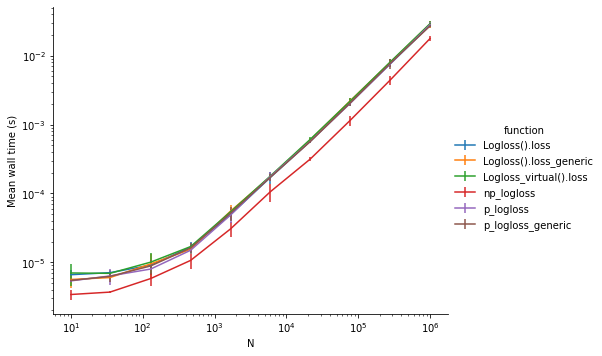

In [23]:
g = sns.FacetGrid(df_loss.wall_time.reset_index(), hue="function", height=5, aspect=4/3)
g.map_dataframe(errplot, "N", "mean", "std")
g.set(xscale="log", yscale="log")
g.set_axis_labels(y_var="Mean wall time (s)")
g.add_legend()

Error propagation: $\sigma^2(x/y) \approx \left(\frac{\partial}{\partial x}\frac{x}{y}\right)^2 \sigma_x^2 + \left(\frac{\partial}{\partial y}\frac{x}{y}\right)^2 \sigma_y^2
= \frac{1}{y^2} \sigma_x^2 + \frac{x^2}{y^4} \sigma_y^2 $

In [24]:
df_reference = df.wall_time.reset_index().query("function == 'np_logloss'")
df_plot = pd.merge(df.wall_time.reset_index(), df_reference, on='N', suffixes=('', '_np'))
df_plot['std'] = np.sqrt(df_plot['std']**2 / df_plot['mean_np']**2
                         + df_plot['mean']**2 / df_plot['mean_np']**4 * df_plot['std_np']**2)
df_plot['mean'] = df_plot['mean'] / df_plot['mean_np']
df_plot = df_plot.loc[:, ['N', 'function', 'mean', 'std']]
df_plot.head()

,N,function,mean,std
0,10,Logloss().loss,1.938074,0.462121
1,10,Logloss().loss_generic,1.652131,0.498412
2,10,Logloss_virtual().loss,2.053569,0.794268
3,10,np_logloss,1.000000,0.238410
4,10,p_logloss,1.577483,0.272954


In [25]:
# shift N slightly to make visualization easier
df_plot.loc[df_plot['function'] =='Logloss().loss', 'N'] *= 0.9
df_plot.loc[df_plot['function'] =='Logloss().loss_generic', 'N'] *= 0.95
df_plot.loc[df_plot['function'] =='Logloss_virtual().loss', 'N'] *= 1.00
df_plot.loc[df_plot['function'] =='p_logloss', 'N'] *= 1.05
df_plot.loc[df_plot['function'] =='p_logloss_generic', 'N'] *= 1.10

Text(0.5, 0.98, 'Ratio of wall time compared to np_logloss')

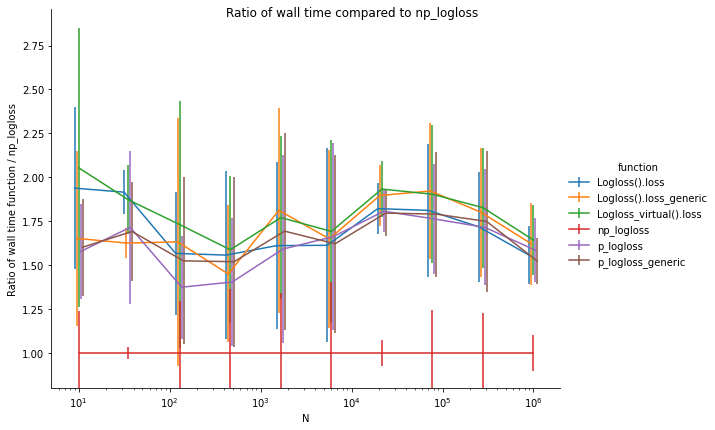

In [26]:
g = sns.FacetGrid(df_plot, hue="function", height=6, aspect=4/3)
g.map_dataframe(errplot, "N", "mean", "std")
g.set(ylim=(0.8, None))
g.set(xscale="log")
g.set_axis_labels(y_var="Ratio of wall time function / np_logloss")
g.add_legend()
g.fig.suptitle("Ratio of wall time compared to np_logloss")

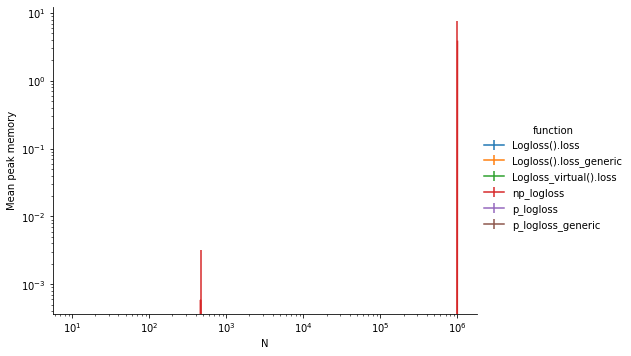

In [27]:
g = sns.FacetGrid(df.peak_memory.reset_index(), hue="function", height=5, aspect=4/3)
g.map_dataframe(errplot, "N", "mean", "std")
g.set(xscale="log", yscale="log")
g.set_axis_labels(y_var="Mean peak memory")
g.add_legend()

### Benchmark Gradient

In [28]:
n_samples = 1000_000
rng = np.random.default_rng(42)
y_pred = rng.standard_normal(n_samples)
raw = rng.standard_normal(n_samples)

func_list = [(np_gradient, "np_gradient"),
             (p_gradient, "p_gradient"),
             (p_gradient_generic, "p_gradient_generic"),
             (Logloss().gradient, "Logloss().gradient"),
             (Logloss().gradient_generic, "Logloss().gradient_generic"),
             (Logloss_virtual().gradient, "Logloss_virtual().gradient")
            ]

def benchmark_cases():
    for N in np.logspace(np.log10(10), np.log10(n_samples), 10).astype('int'):
        for func, name in func_list:
            tags = OrderedDict(N=N, function=name)
            yield delayed(func, tags=tags)(y_pred[:N], raw[:N])

In [29]:
%%time
bench = Benchmark(wall_time={'number': 1}, peak_memory=True, repeat=20)
df_gradient = bench(benchmark_cases())

CPU times: user 10min 4s, sys: 54.1 s, total: 10min 58s
Wall time: 11min 44s


In [30]:
df = df_gradient

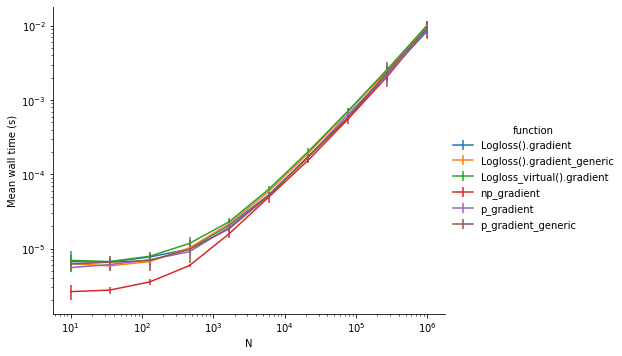

In [31]:
g = sns.FacetGrid(df.wall_time.reset_index(), hue="function", height=5, aspect=4/3)
g.map_dataframe(errplot, "N", "mean", "std")
g.set(xscale="log", yscale="log")
g.set_axis_labels(y_var="Mean wall time (s)")
g.add_legend()

In [32]:
df_reference = df.wall_time.reset_index().query("function == 'np_gradient'")
df_plot = pd.merge(df.wall_time.reset_index(), df_reference, on='N', suffixes=('', '_np'))
df_plot['std'] = np.sqrt(df_plot['std']**2 / df_plot['mean_np']**2
                         + df_plot['mean']**2 / df_plot['mean_np']**4 * df_plot['std_np']**2)
df_plot['mean'] = df_plot['mean'] / df_plot['mean_np']
df_plot = df_plot.loc[:, ['N', 'function', 'mean', 'std']]
df_plot.head()

,N,function,mean,std
0,10,Logloss().gradient,2.532110,0.844441
1,10,Logloss().gradient_generic,2.387265,0.636881
2,10,Logloss_virtual().gradient,2.640838,1.028901
3,10,np_gradient,1.000000,0.324735
4,10,p_gradient,2.109500,0.493899


In [33]:
# shift N slightly to make visualization easier
df_plot.loc[df_plot['function'] =='Logloss().gradient', 'N'] *= 0.9
df_plot.loc[df_plot['function'] =='Logloss().gradient_generic', 'N'] *= 0.95
df_plot.loc[df_plot['function'] =='Logloss_virtual().gradient', 'N'] *= 1.00
df_plot.loc[df_plot['function'] =='p_gradient', 'N'] *= 1.05
df_plot.loc[df_plot['function'] =='p_gradient_generic', 'N'] *= 1.10

Text(0.5, 0.98, 'Ratio of wall time compared to np_gradient')

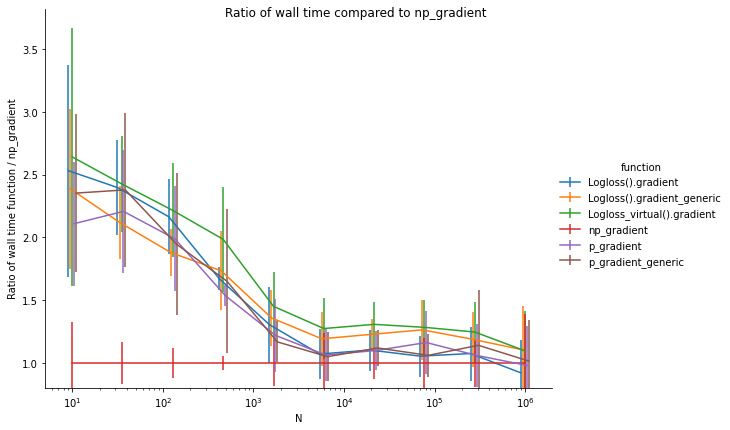

In [34]:
g = sns.FacetGrid(df_plot, hue="function", height=6, aspect=4/3)
g.map_dataframe(errplot, "N", "mean", "std")
g.set(xscale="log")
g.set(ylim=(0.8, None))
g.set_axis_labels(y_var="Ratio of wall time function / np_gradient")
g.add_legend()
g.fig.suptitle("Ratio of wall time compared to np_gradient")

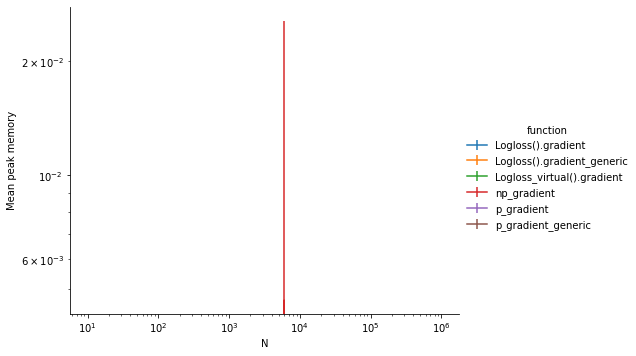

In [35]:
g = sns.FacetGrid(df.peak_memory.reset_index(), hue="function", height=5, aspect=4/3)
g.map_dataframe(errplot, "N", "mean", "std")
g.set(xscale="log", yscale="log")
g.set_axis_labels(y_var="Mean peak memory")
g.add_legend()